In [46]:
! pip install mysql-connector-python

In [47]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy as nltk_accuracy

import mysql.connector
from mysql.connector import Error
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [48]:
connection = mysql.connector.connect(
        host='ds50-mysql-do-user-9644544-0.b.db.ondigitalocean.com',
        database='ds50',
        user='ds50',
        password='AVNS_4ybSd0CoPKnCL5F',
        port = '25060')
if connection.is_connected():
        data = pd.read_sql( '''SELECT * FROM REVIEW LIMIT 5000 
        ''', connection)
        connection.close()
data=pd.DataFrame(data)


C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [49]:
data.head(15)


,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,0000070d5b02a290c631438f4f618c48,644915,2318271,5,"Meski sudah banyak orang tahu buku ini, namun ...",2010-05-13 13:04:33,NaT,0,0
1,00000dd80b43a2cf2afee588cfdd72e2,141599,28954189,5,Death can be cured and aging reversed. The nee...,2017-02-16 19:00:04,2017-03-24 07:00:00,0,0
2,00001391db9e5a03e3f13da55399d427,157659,16043719,2,The Marriage Mistake focuses on Count's younge...,2012-11-30 03:45:25,2012-12-18 08:00:00,0,0
3,00001da050362c5a7eaf6a0614385a29,184748,15507958,5,When I saw the trailer for the movie version o...,2016-08-17 13:31:06,2016-07-27 07:00:00,0,0
4,00002061af3a9f981f601d7f223a6b35,154981,12578313,4,I didn't expect to enjoy this as much as I did...,2013-12-02 21:27:56,NaT,0,0
5,0000271000ca3f0ed54ec992fa502672,57501,13418329,5,In 1999 a friend of mine suggested I read this...,2013-09-07 19:49:37,2017-05-03 07:00:00,0,0
6,00002956a602b00f44b4d2e42eec50b8,105694,15283043,5,This is one of the very few books that I loved...,2013-07-13 15:49:37,NaT,0,0
7,00002e84abd11229f94cad76a601f288,395328,4588,5,Made me cry on the subway- but in a really goo...,2007-12-27 00:57:37,NaT,0,0
8,000039a2fc73f37e615c4acc4498116a,218600,12444166,5,What an awesome read. So kicking myself for pu...,2012-03-29 23:07:35,2013-03-26 07:00:00,1,0
9,00004fead2419af82ee3c84b533dea27,256390,2743,5,I read this many years ago and I still talk ab...,2010-07-27 03:28:05,NaT,0,0


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    5000 non-null   object        
 1   user_id      5000 non-null   int64         
 2   book_id      5000 non-null   int64         
 3   rating       5000 non-null   int64         
 4   review_text  5000 non-null   object        
 5   date_added   5000 non-null   datetime64[ns]
 6   started_at   3000 non-null   datetime64[ns]
 7   n_votes      5000 non-null   int64         
 8   n_comments   5000 non-null   int64         
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 351.7+ KB


In [51]:
data = data[(data['review_text'].str.len() > 3) & (data['review_text'].str.len() < 3000) & (((~ data['review_text'].str.isdigit()) & (data['review_text'].str.len() != 0)) | (data['rating'] != 0))]


In [52]:
data.shape
data[data['rating'] == 0]

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
24,0000cae0b06557b0495712faf7ecd5cb,163574,2728527,0,"Favorite quotes: \n ""I don't want to be marrie...",2013-01-06 22:15:27,NaT,0,0
27,0000d670cf35a0d3b282b75677ebc3e3,155108,6801582,0,Hello,2014-03-23 22:02:32,NaT,0,1
45,00014ce2588a1150b63ad4931f49482d,153431,1582996,0,I love this book. Mortal Instruments have a ve...,2014-02-05 09:25:27,NaT,0,0
51,00018b496d5b68ff7f3f2f2d36342fab,358924,24817626,0,I don't know how to rate this book. It wasn't ...,2015-02-04 03:26:21,2015-08-11 07:00:00,0,0
81,000256fde4288f4ca192a6f6d80b55ed,51641,25695756,0,"Lots of fun, and now I'm ready for a third vol...",2014-01-20 21:09:38,2017-02-20 08:00:00,0,0
...,...,...,...,...,...,...,...,...,...
4872,008d7da722966736f2fb85287648e043,141896,27523,0,"What is it about some books that, though you'r...",2010-01-02 08:52:18,NaT,0,0
4892,008df65f48083c8f330a4905bdb6d30d,241873,17611514,0,Ooh the blurb doesn't give much away but still...,2013-04-05 09:03:07,NaT,2,0
4941,008f3b3bd26c1b9d363dd8f1d60c119d,270724,20910157,0,As if I didn't like and admire Amy Poehler eno...,2015-02-25 21:40:50,NaT,2,0
4946,008f56362b99c5a7a010b7fd110d1b5e,223412,15745753,0,This book made me feel everything. I don't thi...,2013-08-31 18:47:17,NaT,0,0


In [53]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False


In [54]:
import re  
import nltk
nltk.download('stopwords')
 
# to remove stopword
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# for Stemming propose
from nltk.stem.porter import PorterStemmer
corpus = []

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

for j in range(3):
    for i in range(0, len(data)):
        if data['review_text'].iloc[i].isdigit() or isfloat(data['review_text'].iloc[i]):
            if float(data['review_text'].iloc[i])>=0 and float(data['review_text'].iloc[i])<= 1:
                data.loc[i,'review_text']="bad"
            elif float(data['review_text'].iloc[i])>1 and float(data['review_text'].iloc[i])<= 2:
                data.loc[i,'review_text']="not bad"
            elif float(data['review_text'].iloc[i])>2 and float(data['review_text'].iloc[i])<= 3:
                data.loc[i,'review_text']="average"
            elif float(data['review_text'].iloc[i])>3 and float(data['review_text'].iloc[i])<= 4:
                data.loc[i,'review_text']="good"
            elif float(data['review_text'].iloc[i])>4 and float(data['review_text'].iloc[i])<= 5:
                data.loc[i,'review_text']="very good"
            else:
                #si c'est supérieur à 5, on mets le commentaire en fonction de la note attribué
                #print(f"nous sommes ligne {i} et le rating et {data['rating'].iloc[i]}")
                match int(data.loc[i,'rating']):
                    case 1:
                        data.loc[i,'review_text']="bad"
                    case 2:
                        data.loc[i,'review_text']="not bad"
                    case 3:
                        print(f'ligne {i}')
                        data.loc[i,'review_text']="average"
                    case 4:
                        data.loc[i,'review_text']="good"
                    case 5:
                        data.loc[i,'review_text']="very good"
        elif len(data['review_text'].iloc[i]) == 0:
            #si c'est vide, on mets le commentaire en fonction de la note attribué
            #print(f"nous sommes ligne {i} et le rating et {data['rating'].iloc[i]}")
            match int(data.loc[i,'rating']):
                case 1:
                    data.loc[i,'review_text']="bad"
                case 2:
                    data.loc[i,'review_text']="not bad"
                case 3:
                    data.loc[i,'review_text']="average"
                case 4:
                    data.loc[i,'review_text']="good"
                case 5:
                    data.loc[i,'review_text']="very good"         
        else : 
            review = remove_punctuation(data['review_text'].iloc[i])

            # convert all cases to lower cases
            review = review.lower()

            # split to array(default delimiter is " ")
            review = review.split()

            # creating PorterStemmer object to
            # take main stem of each word
            ps = PorterStemmer()

            # loop for stemming each word
            # in string array at ith row   
            review = [ps.stem(word) for word in review
                        if not word in set(stopwords.words('english'))]

            # rejoin all string array elements
            # to create back into a string
            review = ' '.join(review) 

            # append each string to create
            # array of clean text
            corpus.append(review)
            data.loc[i,'review_text']=review

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ligne 795
ligne 3486
ligne 4646
ligne 4646


****Translate****

In [55]:
!pip install -U deep-translator

In [56]:
!pip install langdetect

In [58]:

data[data['rating'] == 0].head()

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
24,0000cae0b06557b0495712faf7ecd5cb,163574.0,2728527.0,0.0,hello,2013-01-06 22:15:27,NaT,0.0,0.0
27,0000d670cf35a0d3b282b75677ebc3e3,155108.0,6801582.0,0.0,ive read book month ago im huge fun stieg lars...,2014-03-23 22:02:32,NaT,0.0,1.0
45,00014ce2588a1150b63ad4931f49482d,153431.0,1582996.0,0.0,dont know rate book wasnt true sequel lee famo...,2014-02-05 09:25:27,NaT,0.0,0.0
51,00018b496d5b68ff7f3f2f2d36342fab,358924.0,24817626.0,0.0,45 star,2015-02-04 03:26:21,2015-08-11 07:00:00,0.0,0.0
81,000256fde4288f4ca192a6f6d80b55ed,51641.0,25695756.0,0.0,look forward book long time disappoint much ju...,2014-01-20 21:09:38,2017-02-20 08:00:00,0.0,0.0


In [59]:
from langdetect import detect 
from deep_translator import GoogleTranslator

try:
    data = data.reset_index()
except Exception:
    print("jeu de données déjà réindexé")

for i in range(0, len(data)):                            

    texte=data['review_text'].iloc[i]
    
    try:
        temp = detect(texte)
    except Exception as lde:
        print(f"Exception : Nous sommes ligne : {i}")
        temp = 'en'

    if (len(texte) != 0 and not texte.isspace())and temp!="en":
        print(f"ligne {i}")
        translated = GoogleTranslator(source='auto', target='en').translate(text=texte)
        data['review_text'].iloc[i]== translated

data.head()

ligne 3
ligne 8
ligne 14
ligne 17
ligne 23
ligne 24
ligne 30
ligne 33
ligne 39
ligne 47
ligne 49
ligne 54
ligne 58
ligne 65
ligne 75
ligne 84
ligne 93
ligne 96
ligne 98
ligne 116
ligne 134
ligne 161
ligne 171
ligne 172
ligne 178
ligne 184
ligne 189
ligne 191
ligne 192
ligne 201
ligne 210
ligne 211
ligne 214
ligne 217
ligne 222
ligne 224
ligne 241
ligne 242
ligne 243
ligne 249
ligne 250
ligne 252
ligne 254
ligne 259
ligne 261
ligne 262
ligne 263
ligne 267
ligne 268
ligne 269
ligne 271
ligne 274
ligne 275
ligne 279
ligne 284
ligne 286
ligne 295
ligne 296
ligne 298
ligne 299
ligne 316
ligne 327
ligne 333
ligne 338
ligne 339
ligne 340
ligne 341
ligne 344
ligne 352
ligne 353
ligne 359
ligne 363
ligne 373
ligne 375
ligne 389
ligne 391
ligne 397
ligne 407
ligne 410
ligne 427
ligne 429
ligne 433
ligne 441
ligne 444
ligne 452
ligne 456
ligne 462
ligne 464
ligne 466
ligne 474
ligne 494
ligne 496
ligne 504
ligne 506
ligne 507
ligne 511
ligne 515
ligne 517
ligne 518
ligne 519
ligne 525
ligne 530
l

,index,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,1,00000dd80b43a2cf2afee588cfdd72e2,141599.0,28954189.0,5.0,didnt expect enjoy much great work good idea n...,2017-02-16 19:00:04,2017-03-24 07:00:00,0.0,0.0
1,2,00001391db9e5a03e3f13da55399d427,157659.0,16043719.0,2.0,1999 friend mine suggest read book tri read sa...,2012-11-30 03:45:25,2012-12-18 08:00:00,0.0,0.0
2,3,00001da050362c5a7eaf6a0614385a29,184748.0,15507958.0,5.0,one book love first sentenc last caymen hilari...,2016-08-17 13:31:06,2016-07-27 07:00:00,0.0,0.0
3,4,00002061af3a9f981f601d7f223a6b35,154981.0,12578313.0,4.0,made cri subway realli good way,2013-12-02 21:27:56,NaT,0.0,0.0
4,5,0000271000ca3f0ed54ec992fa502672,57501.0,13418329.0,5.0,awesom read kick put long think id hate dani p...,2013-09-07 19:49:37,2017-05-03 07:00:00,0.0,0.0


**Ratings count**

<AxesSubplot:xlabel='rating', ylabel='count'>

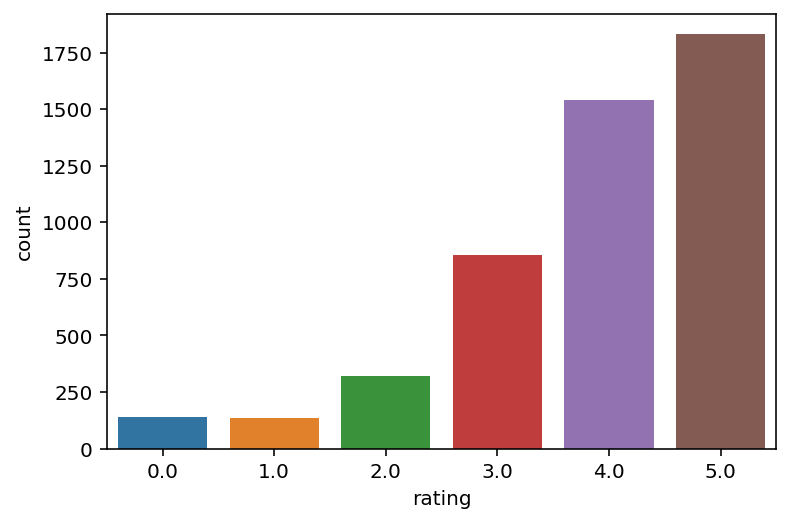

In [60]:
import seaborn as sns
sns.countplot(x=data['rating'],data=data)

In [61]:
ratings_equal_zero=data[data['rating']==0]


In [62]:
data=data[['review_id', 'rating', 'review_text']]
data.head()

,review_id,rating,review_text
0,00000dd80b43a2cf2afee588cfdd72e2,5.0,didnt expect enjoy much great work good idea n...
1,00001391db9e5a03e3f13da55399d427,2.0,1999 friend mine suggest read book tri read sa...
2,00001da050362c5a7eaf6a0614385a29,5.0,one book love first sentenc last caymen hilari...
3,00002061af3a9f981f601d7f223a6b35,4.0,made cri subway realli good way
4,0000271000ca3f0ed54ec992fa502672,5.0,awesom read kick put long think id hate dani p...


In [63]:
rate_id_one = []
rate_id_two = []
rate_id_three = []
rate_id_four = []
rate_id_five =[]


for review_text, rating in zip(data['review_text'], data['rating']):
    line = review_text.split(" ")
    dic = {}
    if rating == 1:
        for word in line:
            dic[word] = True
        ireru = (dic, 1)
        rate_id_one.append(ireru)
    elif rating == 2:
        for word in line:
            dic[word] = True
        ireru = (dic, 2)
        rate_id_two.append(ireru) 
    elif rating == 3:
        for word in line:
            dic[word] = True
        ireru = (dic, 3)
        rate_id_three.append(ireru)
    elif rating == 4:
        for word in line:
            dic[word] = True
        ireru = (dic, 4)
        rate_id_four.append(ireru)
    else:
        for word in line:
            dic[word] = True
        ireru = (dic, 5)
        rate_id_five.append(ireru)


In [64]:
threshold = 0.8
num_one = int(threshold * len(rate_id_one))
num_two = int(threshold * len(rate_id_two))
num_three = int(threshold * len(rate_id_three))
num_four = int(threshold * len(rate_id_four))
num_five = int(threshold * len(rate_id_five))

features_train = rate_id_one[:num_one] + rate_id_two[:num_two] + rate_id_three[:num_three] + rate_id_four[:num_four] + rate_id_five[:num_five]
features_test = rate_id_one[num_one:] + rate_id_two[num_two:] + rate_id_three[num_three:] + rate_id_four[num_four:] + rate_id_five[num_five:]
print("Number of training datapoints:", len(features_train))
print("Number of test datapoints:", len(features_test))

Number of training datapoints: 3998
Number of test datapoints: 1002


In [65]:
classifier = NaiveBayesClassifier.train(features_train)
print('Accuracy of the classifier:', nltk_accuracy(classifier, features_test))

Accuracy of the classifier: 0.17265469061876249


The cause may be that there is a wide range of choices from 1 to 5 and that the absolute number of low-rated sentence data is insufficient. For example, if you choose between 1 and 5 rates, it may improve.

Alternatively, if other methods are used, the accuracy may be further improved, so this will be an issue for the future.

words influenced the predicted numbers during the training.

In [66]:
N = 30
print('Top ' + str(N) + ' most informative words:')
for i, item in enumerate(classifier.most_informative_features()[:N]):
    print(str(i+1) + '. ' + item[0]) 

Top 30 most informative words:
1. welldevelop
2. breakfast
3. clockwork
4. heat
5. 21st
6. champion
7. dorian
8. draco
9. fifth
10. nehemia
11. yay
12. tabl
13. hurri
14. nowher
15. w
16. africa
17. akhr
18. ambigu
19. antholog
20. appli
21. arm
22. asap
23. austin
24. aveng
25. ballad
26. buildup
27. bulli
28. burgeon
29. butterfli
30. byn


In [ ]:
def extract_features(words):
    return dict([(word, True) for word in words])
#Divide into words like the large amount of review text earlier


print("Clothes review predictions:")

 
for i in range(0, len(data)):
    if data['rating'].iloc[i]==0 :
        input_review = data['review_text'].iloc[i]
        features = extract_features(input_review.split())
        probabilities = classifier.prob_classify(features)
        predicted_sentiment = probabilities.max()
        data['rating'].iloc[i]=predicted_sentiment
        

Clothes review predictions:


C:\Users\antoi\AppData\Local\Temp\ipykernel_7600\299568596.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rating'].iloc[i]=predicted_sentiment


In [ ]:
ratings_equal_zero = data[data['rating']==0] 
ratings_equal_zero.head()

,review_id,rating,review_text


there is no ratings equal to 0

In [ ]:
data.head(30)

,review_id,rating,review_text
0,00000dd80b43a2cf2afee588cfdd72e2,5.0,marriag mistak focus count younger sister cari...
1,00001391db9e5a03e3f13da55399d427,2.0,saw trailer movi version book fell love charac...
2,00001da050362c5a7eaf6a0614385a29,5.0,didnt expect enjoy much great work good idea n...
3,00002061af3a9f981f601d7f223a6b35,4.0,1999 friend mine suggest read book tri read sa...
4,0000271000ca3f0ed54ec992fa502672,5.0,one book love first sentenc last caymen hilari...
5,00002956a602b00f44b4d2e42eec50b8,5.0,made cri subway realli good way
6,00002e84abd11229f94cad76a601f288,5.0,awesom read kick put long think id hate dani p...
7,000039a2fc73f37e615c4acc4498116a,5.0,read mani year ago still talk day even though ...
8,00004fead2419af82ee3c84b533dea27,5.0,viciou superpowersurban fantasi interest angl ...
9,000062f0c7b8c3c3ca0c5c280afa3b48,4.0,stori sever famili milwauke struggl make rent ...
